### - Set Up Environment:

In [128]:
import pandas as pd
import numpy as np
import json
import time
from matplotlib_venn import venn2, venn3
from sklearn.metrics.pairwise import cosine_similarity
plt.style.use('seaborn')
import seaborn as sns
import scipy.stats as stats

### - Create a simple server-side application that accesses user related data through the Spotify Web API
(Tutorial at https://developer.spotify.com/documentation/web-api/quick-start/)

### - Install spotipy library and import:

In [129]:
pip install spotipy

Note: you may need to restart the kernel to use updated packages.


In [130]:
f = open('my_secrets.txt', "r")
my_user_id = f.readline()
my_user_id = '1227205646'

%env SPOTIPY_CLIENT_ID = f5aca3c4a8db4243ba150971bdde2a4e
%env SPOTIPY_CLIENT_SECRET= f905f54733484b30a129f4b4be685cc6

env: SPOTIPY_CLIENT_ID=f5aca3c4a8db4243ba150971bdde2a4e
env: SPOTIPY_CLIENT_SECRET=f905f54733484b30a129f4b4be685cc6


In [131]:
import spotipy
from spotipy.oauth2 import SpotifyClientCredentials

sp = spotipy.Spotify(client_credentials_manager=SpotifyClientCredentials())

### - Test Query:

In [132]:
results = sp.search(q='weezer', limit=20)
for idx, track in enumerate(results['tracks']['items']):
    print(idx, track['name'])

0 Island In The Sun
1 Say It Ain't So
2 Buddy Holly
3 Beverly Hills
4 Lost in the Woods - Weezer Version
5 Undone - The Sweater Song
6 Africa
7 Hash Pipe
8 My Name Is Jonas
9 Feels Like Summer
10 Pork And Beans
11 Take On Me
12 The End of the Game
13 El Scorcho
14 Perfect Situation
15 Everybody Wants To Rule The World
16 Only In Dreams
17 The Good Life
18 Mr. Blue Sky
19 The World Has Turned And Left Me Here


### - Create Functions for Web API Gets:

In [133]:
def get_analysis(track_id='4o05DiC0RQ9DNtGJGauwna'):
    '''
    Makes a request to the spotify API that returns an analysis of the track
    
    Parameters:
    track_id: string 
    
    Returns:
    json object
    
    '''
    import json
    import time
    #import sys
    start = time.time()
    analysis = sp.audio_analysis(track_id)
    delta = time.time() - start
    print(json.dumps(analysis, indent=4))
    print("analysis retrieved in %.2f seconds" % (delta,))

In [134]:
def get_features(track_id='4o05DiC0RQ9DNtGJGauwna'):
    '''
    Makes a request to the Spotify API that returns the features of the track.
    
    Parameters:
    track_id: string
    
    Returns:
    json objet
    '''
    import json
    
    features = sp.audio_features(track_id)
    print(json.dumps(features, indent=4))
    return features

In [135]:
def get_playlists(user_id = '1227205646' ): #this is my personal user id
    '''
    Makes a request to the spotify API that returns the playlist objects in a users library
    
    Parameters: 
    user_id: string
    
    Returns: json playlist object
    '''
    playlists = sp.user_playlists(user_id)
    return playlists

In [136]:
def get_tracks(playlist_id):
    '''Takes a playlist id and returns a json object of its tracks'''
    return sp.playlist_tracks(playlist_id)

In [137]:
def get_list_of_playlists(playlists):
    list_of_playlists = []
    for dic in playlists['items']:
        identification = dic['id']
        list_of_playlists.append(identification)
    return list_of_playlists

In [138]:
### Manually get id's for three playlists I'm interested in to start:
global_top50 = "37i9dQZEVXbMDoHDwVN2tF?si=W6KUPczdSc2KL1TKSH-BXA"
usa_top50 = "37i9dQZEVXbLRQDuF5jeBp"
uk_top50 = "1QM1qz09ZzsAPiXphF1l4S"
mexico_top50 = '37i9dQZEVXbO3qyFxbkOE1'
canada_top50 = '37i9dQZEVXbKj23U1GF4IR'
# top 50 as of 0900AM EST 07APR2020

In [139]:
### Function for selecting only the track id's from a playlist (previous function returned the entire 'tracks' json object)
def getTrackIDs(user, playlist_id): 
    ids = []
    playlist = sp.user_playlist(user, playlist_id)
    for item in playlist['tracks']['items']:
        track = item['track']
        ids.append(track['id'])
    return ids

In [140]:
#get track ids for the three playlists I chose
global_ids = getTrackIDs(my_user_id, global_top50) # for this function to work, playlist must be in my personal library even if it is a public playlist
usa_ids = getTrackIDs(my_user_id, usa_top50)
uk_ids = getTrackIDs(my_user_id, uk_top50)
mex_ids = getTrackIDs(my_user_id, mexico_top50)
can_ids =getTrackIDs(my_user_id, canada_top50)

In [141]:
def get_Genres(artist_id):
    artist = sp.artist(artist_id)
    genres = artist["genres"]
    return genres
get_Genres('1Xyo4u8uXC1ZmMpatF05PJ') #test

['canadian contemporary r&b', 'canadian pop', 'pop']

###### Function modifed from code in Medium Article - https://medium.com/better-programming/how-to-extract-any-artists-data-using-spotify-s-api-python-and-spotipy-4c079401bc37

In [142]:
### Collect only the fields we want for each track
def getTrackFeatures(id):
    meta = sp.track(id)
    features = sp.audio_features(id)
    if features[0] is None: #if features is NoneType, don't collect data for that track
        return

    # meta
    name = meta['name']
    album = meta['album']['name']
    artist = meta['album']['artists'][0]['name']
    artist_id = meta['album']['artists'][0]['id']
    genres = get_Genres(artist_id)
    #release_date = meta['album']['release_date']
    #length = meta['duration_ms']
    #popularity = meta['popularity']

    # features
    acousticness = features[0]['acousticness']
    danceability = features[0]['danceability']
    energy = features[0]['energy']
    instrumentalness = features[0]['instrumentalness']
    liveness = features[0]['liveness']
    loudness = features[0]['loudness']
    speechiness = features[0]['speechiness']
    tempo = features[0]['tempo']
    #time_signature = features[0]['time_signature']
    
    track = [id, name, album, artist, artist_id, genres, acousticness, danceability, energy, instrumentalness, liveness, loudness, speechiness, tempo]
    #track = [name, album, artist, release_date, length, popularity, danceability, acousticness, danceability, energy, instrumentalness, liveness, loudness, speechiness, tempo, time_signature]
    return track

###### Function modifed from code in Medium Article - https://medium.com/better-programming/how-to-extract-any-artists-data-using-spotify-s-api-python-and-spotipy-4c079401bc37

In [143]:
def features_for_ids(ids):
    # loop over track ids 
    tracks = []
    #for i in range(3):
    for i in range(len(ids)):
        time.sleep(.5)
        track = getTrackFeatures(ids[i])
        if track is None: #if track features is NoneType, don't add the track to database
            pass
        else:
            tracks.append(track)

        # create dataset
    df = pd.DataFrame(tracks, columns = ['track_id', 'name', 'album', 'artist', 'artist_id', 'genres', 'acousticness', 'danceability', 'energy', 'instrumentalness', 'liveness', 'loudness', 'speechiness', 'tempo'])
        #df.to_csv("spotify.csv", sep = ',')
    #normalize the tempo and loudness using min-max normilization
    df['tempo'] = ((df['tempo'] - df['tempo'].min()) / (df['tempo'].max() - df['tempo'].min()))
    df['loudness'] =  ((df['loudness'] - df['loudness'].min()) / (df['loudness'].max() - df['loudness'].min()))
    return df

### - Create DataFrames for Each Playlist:

In [144]:
global_df = features_for_ids(global_ids)
usa_df = features_for_ids(usa_ids)
uk_df = features_for_ids(uk_ids)
mex_df = features_for_ids(mex_ids)
can_df = features_for_ids(can_ids)
all_df = global_df.append(usa_df, ignore_index=True).append(uk_df, ignore_index=True).append(mex_df, ignore_index=True).append(can_df, ignore_index=True)

In [145]:
print('global_df')
global_df.head()
print('usa_df')
usa_df.head()
print('uk_df')
uk_df.head()
print('mex_df')
mex_df.head()
print('can_df')
can_df.head()
print('all_df')
all_df.head()

global_df


,track_id,name,album,artist,artist_id,genres,acousticness,danceability,energy,instrumentalness,liveness,loudness,speechiness,tempo
0,0VjIjW4GlUZAMYd2vXMi3b,Blinding Lights,After Hours,The Weeknd,1Xyo4u8uXC1ZmMpatF05PJ,"[canadian contemporary r&b, canadian pop, pop]",0.00146,0.514,0.730,0.000095,0.0897,0.741063,0.0598,0.806165
1,127QTOFJsJQp5LbJbu3A1y,Toosie Slide,Toosie Slide,Drake,3TVXtAsR1Inumwj472S9r4,"[canadian hip hop, canadian pop, hip hop, pop ...",0.32100,0.834,0.454,0.000006,0.1140,0.409150,0.2010,0.049257
2,24Yi9hE78yPEbZ4kxyoXAI,Roses - Imanbek Remix,Roses (Imanbek Remix),SAINt JHN,0H39MdGGX6dbnnQPt6NQkZ,"[melodic rap, pop rap, rap, trap]",0.01670,0.770,0.724,0.010500,0.3530,0.780204,0.0495,0.390982
3,3PfIrDoz19wz7qK7tYeu62,Don't Start Now,Future Nostalgia,Dua Lipa,6M2wZ9GZgrQXHCFfjv46we,"[dance pop, pop, uk pop]",0.01250,0.794,0.793,0.000000,0.0952,0.863965,0.0842,0.407638
4,0nbXyq5TXYPCO7pr3N8S4I,The Box,Please Excuse Me For Being Antisocial,Roddy Ricch,757aE44tKEUQEqRuT6GnEB,[melodic rap],0.10400,0.896,0.586,0.000000,0.7900,0.675568,0.0559,0.348618


usa_df


,track_id,name,album,artist,artist_id,genres,acousticness,danceability,energy,instrumentalness,liveness,loudness,speechiness,tempo
0,127QTOFJsJQp5LbJbu3A1y,Toosie Slide,Toosie Slide,Drake,3TVXtAsR1Inumwj472S9r4,"[canadian hip hop, canadian pop, hip hop, pop ...",0.32100,0.834,0.454,0.000006,0.1140,0.416431,0.2010,0.055799
1,0nbXyq5TXYPCO7pr3N8S4I,The Box,Please Excuse Me For Being Antisocial,Roddy Ricch,757aE44tKEUQEqRuT6GnEB,[melodic rap],0.10400,0.896,0.586,0.000000,0.7900,0.687589,0.0559,0.394916
2,0VjIjW4GlUZAMYd2vXMi3b,Blinding Lights,After Hours,The Weeknd,1Xyo4u8uXC1ZmMpatF05PJ,"[canadian contemporary r&b, canadian pop, pop]",0.00146,0.514,0.730,0.000095,0.0897,0.754249,0.0598,0.913228
3,22LAwLoDA5b4AaGSkg6bKW,Blueberry Faygo,Certified Hitmaker,Lil Mosey,5zctI4wO9XSKS8XwcnqEHk,"[melodic rap, rap, rap conscient, trap, vapor ...",0.20700,0.774,0.554,0.000000,0.1320,0.579409,0.0383,0.222859
4,24Yi9hE78yPEbZ4kxyoXAI,Roses - Imanbek Remix,Roses (Imanbek Remix),SAINt JHN,0H39MdGGX6dbnnQPt6NQkZ,"[melodic rap, pop rap, rap, trap]",0.01670,0.770,0.724,0.010500,0.3530,0.794086,0.0495,0.442906


uk_df


,track_id,name,album,artist,artist_id,genres,acousticness,danceability,energy,instrumentalness,liveness,loudness,speechiness,tempo
0,5px6upUHM3fhOP621Edp4V,Physical,Physical,Dua Lipa,6M2wZ9GZgrQXHCFfjv46we,"[dance pop, pop, uk pop]",0.0137,0.647,0.844,0.000658,0.102,0.877956,0.0457,0.752368
1,2ZEq4HT450Ye9IFGPTl9qV,Lonely,Lonely,Joel Corry,6DgP9otnZw5z6daOntINxp,"[deep groove house, house, uk dance]",0.0946,0.697,0.921,0.000019,0.159,0.815330,0.0424,0.515864
2,5aYWnrsYvJk8NT7PmUcxVN,Flowers (feat. Jaykae),Flowers (feat. Jaykae),Nathan Dawe,2gduEC76ry33RVurAvT05p,"[deep groove house, house, uk dance]",0.0150,0.672,0.925,0.000000,0.289,0.787522,0.0774,0.537564
3,24Yi9hE78yPEbZ4kxyoXAI,Roses - Imanbek Remix,Roses (Imanbek Remix),SAINt JHN,0H39MdGGX6dbnnQPt6NQkZ,"[melodic rap, pop rap, rap, trap]",0.0167,0.770,0.724,0.010500,0.353,0.672608,0.0495,0.495131
4,2XU0oxnq2qxCpomAAuJY8K,Dance Monkey,Dance Monkey (Stripped Back) / Dance Monkey,Tones And I,2NjfBq1NflQcKSeiDooVjY,[australian pop],0.6920,0.824,0.588,0.000104,0.149,0.563755,0.0924,0.248610


mex_df


,track_id,name,album,artist,artist_id,genres,acousticness,danceability,energy,instrumentalness,liveness,loudness,speechiness,tempo
0,2DEZmgHKAvm41k4J3R2E9Y,Safaera,YHLQMDLG,Bad Bunny,4q3ewBCX7sLwd24euuV69X,"[latin, reggaeton, trap latino]",0.01030,0.607,0.829,0.000000,0.1070,0.717607,0.3790,0.076193
1,0SqqAgdovOE24BzxIClpjw,Yo Perreo Sola,YHLQMDLG,Bad Bunny,4q3ewBCX7sLwd24euuV69X,"[latin, reggaeton, trap latino]",0.02100,0.860,0.758,0.000065,0.3440,0.551476,0.0695,0.084017
2,380HmhwTE2NJgawn1NwkXi,Rojo,Colores,J Balvin,1vyhD5VmyZ7KMfW5gqLgo5,"[latin, reggaeton]",0.19300,0.663,0.598,0.000080,0.0856,0.722503,0.1700,0.783053
3,41wtwzCZkXwpnakmwJ239F,Si Veo a Tu Mamá,YHLQMDLG,Bad Bunny,4q3ewBCX7sLwd24euuV69X,"[latin, reggaeton, trap latino]",0.40200,0.900,0.603,0.000005,0.1340,0.528071,0.0646,0.389850
4,0VjIjW4GlUZAMYd2vXMi3b,Blinding Lights,After Hours,The Weeknd,1Xyo4u8uXC1ZmMpatF05PJ,"[canadian contemporary r&b, canadian pop, pop]",0.00146,0.514,0.730,0.000095,0.0897,0.433073,0.0598,0.771532


can_df


,track_id,name,album,artist,artist_id,genres,acousticness,danceability,energy,instrumentalness,liveness,loudness,speechiness,tempo
0,127QTOFJsJQp5LbJbu3A1y,Toosie Slide,Toosie Slide,Drake,3TVXtAsR1Inumwj472S9r4,"[canadian hip hop, canadian pop, hip hop, pop ...",0.32100,0.834,0.454,0.000006,0.1140,0.426860,0.2010,0.061100
1,0VjIjW4GlUZAMYd2vXMi3b,Blinding Lights,After Hours,The Weeknd,1Xyo4u8uXC1ZmMpatF05PJ,"[canadian contemporary r&b, canadian pop, pop]",0.00146,0.514,0.730,0.000095,0.0897,0.773140,0.0598,1.000000
2,24Yi9hE78yPEbZ4kxyoXAI,Roses - Imanbek Remix,Roses (Imanbek Remix),SAINt JHN,0H39MdGGX6dbnnQPt6NQkZ,"[melodic rap, pop rap, rap, trap]",0.01670,0.770,0.724,0.010500,0.3530,0.813975,0.0495,0.484990
3,22LAwLoDA5b4AaGSkg6bKW,Blueberry Faygo,Certified Hitmaker,Lil Mosey,5zctI4wO9XSKS8XwcnqEHk,"[melodic rap, rap, rap conscient, trap, vapor ...",0.20700,0.774,0.554,0.000000,0.1320,0.593920,0.0383,0.244034
4,0nbXyq5TXYPCO7pr3N8S4I,The Box,Please Excuse Me For Being Antisocial,Roddy Ricch,757aE44tKEUQEqRuT6GnEB,[melodic rap],0.10400,0.896,0.586,0.000000,0.7900,0.704809,0.0559,0.432440


all_df


,track_id,name,album,artist,artist_id,genres,acousticness,danceability,energy,instrumentalness,liveness,loudness,speechiness,tempo
0,0VjIjW4GlUZAMYd2vXMi3b,Blinding Lights,After Hours,The Weeknd,1Xyo4u8uXC1ZmMpatF05PJ,"[canadian contemporary r&b, canadian pop, pop]",0.00146,0.514,0.730,0.000095,0.0897,0.741063,0.0598,0.806165
1,127QTOFJsJQp5LbJbu3A1y,Toosie Slide,Toosie Slide,Drake,3TVXtAsR1Inumwj472S9r4,"[canadian hip hop, canadian pop, hip hop, pop ...",0.32100,0.834,0.454,0.000006,0.1140,0.409150,0.2010,0.049257
2,24Yi9hE78yPEbZ4kxyoXAI,Roses - Imanbek Remix,Roses (Imanbek Remix),SAINt JHN,0H39MdGGX6dbnnQPt6NQkZ,"[melodic rap, pop rap, rap, trap]",0.01670,0.770,0.724,0.010500,0.3530,0.780204,0.0495,0.390982
3,3PfIrDoz19wz7qK7tYeu62,Don't Start Now,Future Nostalgia,Dua Lipa,6M2wZ9GZgrQXHCFfjv46we,"[dance pop, pop, uk pop]",0.01250,0.794,0.793,0.000000,0.0952,0.863965,0.0842,0.407638
4,0nbXyq5TXYPCO7pr3N8S4I,The Box,Please Excuse Me For Being Antisocial,Roddy Ricch,757aE44tKEUQEqRuT6GnEB,[melodic rap],0.10400,0.896,0.586,0.000000,0.7900,0.675568,0.0559,0.348618


In [146]:
print('global_df')
global_df.describe()
print('usa_df')
usa_df.describe()
print('uk_df')
uk_df.describe()
print('mex_df')
mex_df.describe()
print('can_df')
can_df.describe()
print('all_df')
all_df.describe()

global_df


,acousticness,danceability,energy,instrumentalness,liveness,loudness,speechiness,tempo
count,50.000000,50.000000,50.000000,5.000000e+01,50.000000,50.000000,50.000000,50.000000
mean,0.228884,0.743000,0.621500,1.648593e-02,0.175262,0.729349,0.134052,0.394828
std,0.247243,0.123907,0.152128,9.424920e-02,0.158205,0.192357,0.109738,0.227776
min,0.001460,0.430000,0.225000,0.000000e+00,0.057400,0.000000,0.029000,0.000000
25%,0.042450,0.676000,0.538500,0.000000e+00,0.088950,0.671458,0.056250,0.207342
50%,0.156000,0.767000,0.613000,6.950000e-07,0.106500,0.769027,0.092200,0.352754
75%,0.298750,0.835500,0.729750,8.080000e-05,0.194000,0.858746,0.179000,0.546245
max,0.902000,0.923000,0.955000,6.570000e-01,0.790000,1.000000,0.481000,1.000000


usa_df


,acousticness,danceability,energy,instrumentalness,liveness,loudness,speechiness,tempo
count,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000
mean,0.204418,0.742680,0.621620,0.013529,0.199644,0.745830,0.141074,0.468402
std,0.234571,0.127282,0.136684,0.092874,0.158545,0.179185,0.108478,0.249240
min,0.001460,0.430000,0.225000,0.000000,0.059600,0.000000,0.030500,0.000000
25%,0.034275,0.678500,0.545250,0.000000,0.099750,0.683406,0.056300,0.275192
50%,0.125000,0.772500,0.613000,0.000000,0.135000,0.785588,0.099100,0.433842
75%,0.268750,0.835500,0.729750,0.000001,0.258000,0.857737,0.200750,0.642113
max,0.902000,0.923000,0.955000,0.657000,0.790000,1.000000,0.481000,1.000000


uk_df


,acousticness,danceability,energy,instrumentalness,liveness,loudness,speechiness,tempo
count,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000
mean,0.207442,0.678520,0.683640,0.003682,0.193468,0.686225,0.085470,0.408333
std,0.239954,0.115643,0.169296,0.017555,0.156778,0.205632,0.069539,0.231668
min,0.001470,0.420000,0.267000,0.000000,0.044000,0.000000,0.028700,0.000000
25%,0.041725,0.602750,0.599750,0.000000,0.094150,0.565983,0.042575,0.229182
50%,0.122500,0.672000,0.690500,0.000000,0.149000,0.715686,0.055000,0.423250
75%,0.253750,0.746250,0.797500,0.000011,0.212500,0.836185,0.106350,0.533923
max,0.913000,0.922000,0.955000,0.110000,0.790000,1.000000,0.352000,1.000000


mex_df


,acousticness,danceability,energy,instrumentalness,liveness,loudness,speechiness,tempo
count,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000
mean,0.217191,0.747380,0.697160,0.004803,0.153786,0.648386,0.111526,0.356524
std,0.204040,0.106457,0.119235,0.029109,0.129272,0.194281,0.088228,0.331358
min,0.001460,0.504000,0.350000,0.000000,0.053100,0.000000,0.032000,0.000000
25%,0.036300,0.656250,0.625750,0.000000,0.082200,0.532584,0.057550,0.075197
50%,0.168000,0.754500,0.714500,0.000007,0.103000,0.654352,0.076200,0.223144
75%,0.326500,0.838500,0.789750,0.000113,0.165750,0.768892,0.130750,0.669797
max,0.784000,0.900000,0.911000,0.206000,0.696000,1.000000,0.379000,1.000000


can_df


,acousticness,danceability,energy,instrumentalness,liveness,loudness,speechiness,tempo
count,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000
mean,0.248432,0.730980,0.587540,0.016348,0.182444,0.729915,0.121506,0.463954
std,0.256041,0.122359,0.141568,0.094271,0.159623,0.197783,0.105020,0.260617
min,0.001460,0.430000,0.225000,0.000000,0.055400,0.000000,0.025900,0.000000
25%,0.052900,0.669250,0.504750,0.000000,0.089875,0.681851,0.050475,0.254299
50%,0.160000,0.761500,0.589500,0.000000,0.110000,0.777813,0.080900,0.432419
75%,0.317000,0.821000,0.714250,0.000007,0.211000,0.854492,0.156000,0.646294
max,0.902000,0.923000,0.955000,0.657000,0.790000,1.000000,0.481000,1.000000


all_df


,acousticness,danceability,energy,instrumentalness,liveness,loudness,speechiness,tempo
count,250.000000,250.000000,250.000000,250.000000,250.000000,250.000000,250.000000,250.000000
mean,0.221274,0.728512,0.642292,0.010969,0.180921,0.707941,0.118726,0.418408
std,0.235669,0.121138,0.149449,0.073846,0.152539,0.195782,0.098594,0.264175
min,0.001460,0.420000,0.225000,0.000000,0.044000,0.000000,0.025900,0.000000
25%,0.039825,0.654250,0.549500,0.000000,0.089700,0.611672,0.049500,0.213637
50%,0.145000,0.740500,0.644000,0.000000,0.114000,0.751942,0.079600,0.390352
75%,0.300000,0.824750,0.745000,0.000037,0.214000,0.839047,0.158000,0.591439
max,0.913000,0.923000,0.955000,0.657000,0.790000,1.000000,0.481000,1.000000


In [147]:
global_set = set(global_df.name)
usa_set = set(usa_df.name)
uk_set = set(uk_df.name)
mex_set = set(mex_df.name)
can_set = set(can_df.name)
set_list = [global_set, usa_set, uk_set, mex_set, can_set]

### Questions:

#### What is the intersection set of Global Top 50 and USA Top 50?

<Figure size 576x396 with 0 Axes>

Text(0.5, 1.0, 'Intersection of Top 50 Tracks')

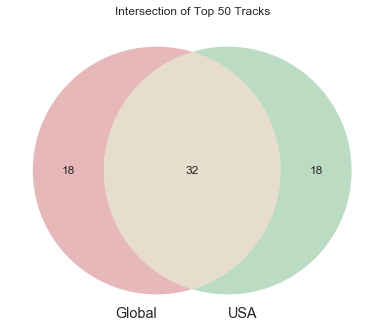

In [148]:
plt.figure(facecolor='white')
fig1 = venn2([global_set, usa_set],('Global', 'USA'))
plt.title('Intersection of Top 50 Tracks')
plt.savefig('global_U_usa', dpi=240)

#### How does this compare to the Intersection Sets w/ other countries?

<Figure size 576x396 with 0 Axes>

Text(0.5, 1.0, 'Intersection of Top 50 Tracks')

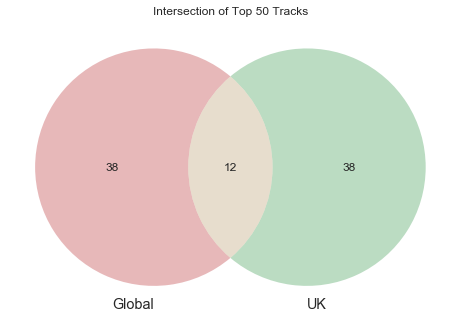

In [149]:
plt.figure(facecolor='white')
fig2 = venn2([global_set, uk_set], ('Global', 'UK'))
plt.title('Intersection of Top 50 Tracks')
plt.savefig('global_U_uk', dpi=240)

<Figure size 576x396 with 0 Axes>

Text(0.5, 1.0, 'Intersection of Top 50 Tracks')

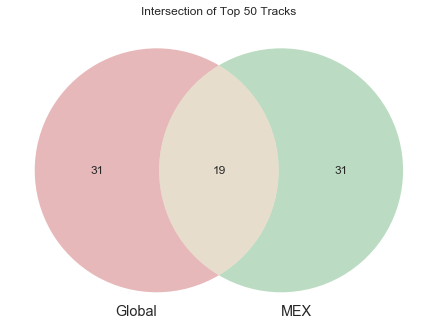

In [150]:
plt.figure(facecolor='white')
fig3 = venn2([global_set, mex_set], ('Global', 'MEX'))
plt.title('Intersection of Top 50 Tracks')
plt.savefig('global_U_mex', dpi=240)

<Figure size 576x396 with 0 Axes>

Text(0.5, 1.0, 'Intersection of Top 50 Tracks')

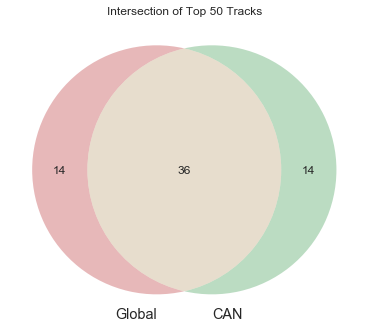

In [151]:
plt.figure(facecolor='white')
fig3 = venn2([global_set, can_set], ('Global', 'CAN'))
plt.title('Intersection of Top 50 Tracks')
plt.savefig('global_U_can', dpi=240)

<Figure size 576x396 with 0 Axes>

Text(0.5, 1.0, 'Intersection of Top 50 Tracks')

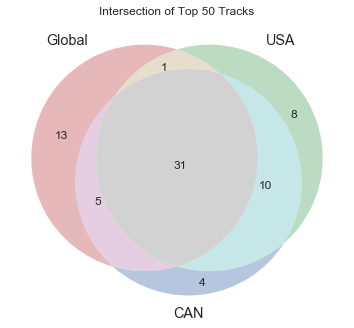

In [152]:
plt.figure(facecolor='white')
venn3([global_set, usa_set, can_set], ('Global', 'USA', 'CAN'))
plt.title('Intersection of Top 50 Tracks')
plt.savefig('global_U_usa_U_can', dpi=240)

#### Do the averages of the features of the Global Top 50 differ significantly from those of USA Top 50?

#### What is the correlation between features?

Text(0.5, 1, 'Track Features Correlation for All Regions Data')

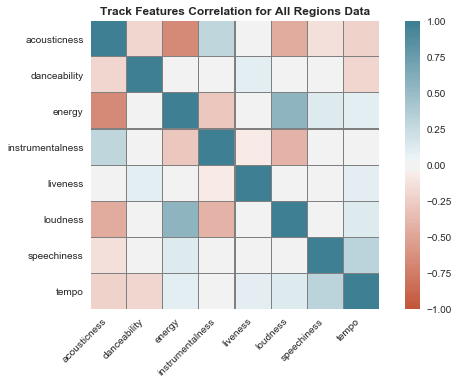

In [153]:
def feature_correlation_map(dataframe):
    corr = dataframe.corr()
    ax = sns.heatmap(
    corr,
    vmin=-1, vmax=1, center=0,
    cmap=sns.diverging_palette(20, 220, n=200),
    square=True,
    linewidth=.1,
    linecolor='gray'
    )
    ax.set_xticklabels(
    ax.get_xticklabels(),
    rotation=45,
    horizontalalignment='right'
)

feature_correlation_map(all_df)
plt.title('Track Features Correlation for All Regions Data', fontsize=12, fontweight='bold')
plt.tight_layout()
plt.savefig('all_data_feature_correlation', dpi=240)

In [154]:
global_vec = global_df.describe().loc['mean'].to_frame(name='global').transpose()
usa_vec = usa_df.describe().loc['mean'].to_frame(name='usa').transpose()
uk_vec = uk_df.describe().loc['mean'].to_frame(name='uk').transpose()
mex_vec = mex_df.describe().loc['mean'].to_frame(name='mex').transpose()
can_vec = can_df.describe().loc['mean'].to_frame(name='can').transpose()
mean_features_df = global_vec.append(usa_vec).append(uk_vec).append(mex_vec).append(can_vec)
mean_features_df.head()

,acousticness,danceability,energy,instrumentalness,liveness,loudness,speechiness,tempo
global,0.228884,0.74300,0.62150,0.016486,0.175262,0.729349,0.134052,0.394828
usa,0.204418,0.74268,0.62162,0.013529,0.199644,0.745830,0.141074,0.468402
uk,0.207442,0.67852,0.68364,0.003682,0.193468,0.686225,0.085470,0.408333
mex,0.217191,0.74738,0.69716,0.004803,0.153786,0.648386,0.111526,0.356524
can,0.248432,0.73098,0.58754,0.016348,0.182444,0.729915,0.121506,0.463954


#### Which country's musical taste is most similar to USA? (using similarity of feature vectors)

In [155]:
from sklearn.metrics.pairwise import cosine_similarity

similarity_matrix = cosine_similarity(mean_features_df)
similarity_matrix
#resulting matrix shows extreme similarity across the board. Will normalizing the dataframe help distinguish?

array([[1.        , 0.99834942, 0.99628402, 0.99570644, 0.99808002],
       [0.99834942, 1.        , 0.99579612, 0.99192986, 0.99905862],
       [0.99628402, 0.99579612, 1.        , 0.99660026, 0.99433604],
       [0.99570644, 0.99192986, 0.99660026, 1.        , 0.99064101],
       [0.99808002, 0.99905862, 0.99433604, 0.99064101, 1.        ]])

In [156]:
normalized_features_df=(mean_features_df-mean_features_df.mean())/mean_features_df.std()
normalized_similarity_matrix = cosine_similarity(normalized_features_df)
normalized_similarity_matrix

array([[ 1.        ,  0.20840688, -0.86327126, -0.22073959,  0.48865663],
       [ 0.20840688,  1.        , -0.36310879, -0.70790195,  0.2200034 ],
       [-0.86327126, -0.36310879,  1.        ,  0.19272598, -0.56203496],
       [-0.22073959, -0.70790195,  0.19272598,  1.        , -0.66047979],
       [ 0.48865663,  0.2200034 , -0.56203496, -0.66047979,  1.        ]])

In [157]:
#turn the similarity matrix back into a dataframe with labels
similarity_df = pd.DataFrame(normalized_similarity_matrix, index=mean_features_df.index, columns=mean_features_df.index)
similarity_df

,global,usa,uk,mex,can
global,1.000000,0.208407,-0.863271,-0.220740,0.488657
usa,0.208407,1.000000,-0.363109,-0.707902,0.220003
uk,-0.863271,-0.363109,1.000000,0.192726,-0.562035
mex,-0.220740,-0.707902,0.192726,1.000000,-0.660480
can,0.488657,0.220003,-0.562035,-0.660480,1.000000


Text(0.5, 1, 'Track Features Cosine-Similarity Heatmap')

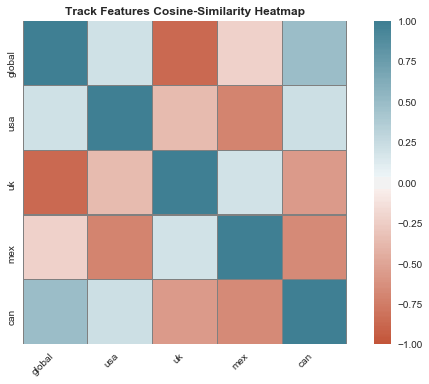

In [158]:
#visualize with with a heatmap
def similarity_heatmap(dataframe):
    ax = sns.heatmap(
        dataframe,
        vmin=-1, vmax=1, center=0,
        cmap=sns.diverging_palette(20, 220, n=200),
        square=True,
        linewidth=.1,
        linecolor='gray'
        )
    ax.set_xticklabels(
        ax.get_xticklabels(),
        rotation=45,
        horizontalalignment='right');

similarity_heatmap(similarity_df)
plt.title('Track Features Cosine-Similarity Heatmap', fontsize=12, fontweight='bold')
plt.tight_layout()
plt.savefig('feature_similarity_heatmap', dpi=240)

#### Which country's musical taste is most similar to USA? (using similarity of genre strings, vectorized)
###### (Scikit methods adapted from https://www.machinelearningplus.com/nlp/cosine-similarity/)

In [159]:
#write a function that takes the genres from every song in a playlist and combines them into one string
def string_all_genres(df):
    '''
    Take the genre column (which containes lists of strings), and combine every string from each row into one output string as document.
    '''
    
    document = ''
    for genre_list in df.genres:
        for string in genre_list:
            document += ' ' + string
    return document

In [160]:
global_genres = string_all_genres(global_df)
usa_genres = string_all_genres(usa_df)
uk_genres = string_all_genres(uk_df)
mex_genres = string_all_genres(mex_df)
can_genres = string_all_genres(can_df)
documents = [global_genres, usa_genres, uk_genres, mex_genres, can_genres]

In [161]:
# Scikit Learn
from sklearn.feature_extraction.text import CountVectorizer

# Create the Document Term Matrix
count_vectorizer = CountVectorizer(stop_words='english')
count_vectorizer = CountVectorizer()
sparse_matrix = count_vectorizer.fit_transform(documents)

# OPTIONAL: Convert Sparse Matrix to Pandas Dataframe if you want to see the word frequencies.
doc_term_matrix = sparse_matrix.todense()
genre_frequency_df = pd.DataFrame(doc_term_matrix, 
                  columns=count_vectorizer.get_feature_names(), 
                  index=['global_genres', 'usa_genres', 'uk_genres', 'mex_genres', 'can_genres'])

#inspect columns, check for any that should be combined
genre_frequency_df.columns

# 'hip hop' should be counted one genre, not two separate ones. Everything else looks fine.
genre_frequency_df['hip hop'] = genre_frequency_df['hip']
genre_frequency_df.drop(columns=['hip', 'hop'], inplace=True)
genre_frequency_df

Index(['alternative', 'anthem', 'atl', 'australian', 'baroque', 'bedroom',
       'cafe', 'cali', 'canadian', 'chicago', 'colombian', 'conscient',
       'contemporary', 'corrido', 'country', 'dance', 'deep', 'detroit', 'dfw',
       'drill', 'edm', 'electro', 'electropop', 'emo', 'en', 'escape',
       'espanol', 'etherpop', 'euro', 'florida', 'flow', 'folk', 'funk',
       'funky', 'german', 'grime', 'groove', 'hip', 'hop', 'house', 'houston',
       'indie', 'indietronica', 'la', 'latin', 'latino', 'liquid', 'mellow',
       'melodic', 'meme', 'memphis', 'mexican', 'minnesota', 'modern', 'nc',
       'neo', 'nz', 'permanent', 'philly', 'pop', 'poptimism', 'post', 'queen',
       'rap', 'reggaeton', 'regional', 'revival', 'rock', 'room', 'show',
       'soul', 'southern', 'talent', 'teen', 'toronto', 'trap', 'tropical',
       'uk', 'ukg', 'underground', 'urban', 'vapor', 'viral', 'wave'],
      dtype='object')

,alternative,anthem,atl,australian,baroque,bedroom,cafe,cali,canadian,chicago,...,trap,tropical,uk,ukg,underground,urban,vapor,viral,wave,hip hop
global_genres,1,0,1,1,0,1,0,0,13,0,...,14,1,5,0,2,1,1,1,0,12
usa_genres,1,0,4,1,0,1,0,2,13,5,...,14,0,3,0,3,1,2,0,0,22
uk_genres,1,1,0,2,1,0,2,0,4,0,...,4,15,24,1,2,1,0,0,1,7
mex_genres,0,0,0,1,0,0,0,0,2,0,...,18,1,3,0,0,0,0,2,0,1
can_genres,1,0,2,1,0,1,0,2,15,0,...,11,0,4,0,3,1,2,1,0,19


array([[ 1.        ,  0.27489983, -0.60294686, -0.14505933,  0.42086841],
       [ 0.27489983,  1.        , -0.5900605 , -0.40029838,  0.47845743],
       [-0.60294686, -0.5900605 ,  1.        , -0.25004628, -0.51287444],
       [-0.14505933, -0.40029838, -0.25004628,  1.        , -0.51619511],
       [ 0.42086841,  0.47845743, -0.51287444, -0.51619511,  1.        ]])

,global_genres,usa_genres,uk_genres,mex_genres,can_genres
global_genres,1.000000,0.274900,-0.602947,-0.145059,0.420868
usa_genres,0.274900,1.000000,-0.590060,-0.400298,0.478457
uk_genres,-0.602947,-0.590060,1.000000,-0.250046,-0.512874
mex_genres,-0.145059,-0.400298,-0.250046,1.000000,-0.516195
can_genres,0.420868,0.478457,-0.512874,-0.516195,1.000000


Text(0.5, 1, 'Genre Frequency Cosine Similarity Heatmap')

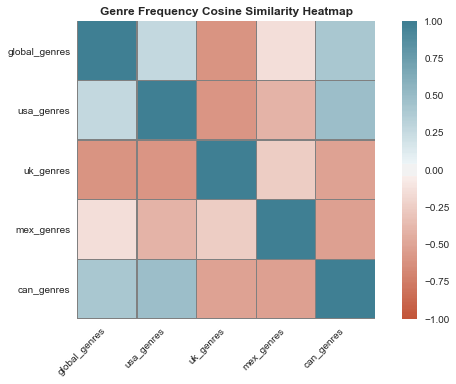

In [162]:
#normalize the dataframe like we did for the features dataframe
normalized_genre_df=(genre_frequency_df-genre_frequency_df.mean())/genre_frequency_df.std()

# calculate genre cosine similarity
genre_similarity = cosine_similarity(normalized_genre_df)
genre_similarity

#change back to dataframe
genre_similarity_df = pd.DataFrame(genre_similarity, columns=genre_frequency_df.index, index=genre_frequency_df.index)
genre_similarity_df

#heatmap
similarity_heatmap(genre_similarity_df)
plt.title('Genre Frequency Cosine Similarity Heatmap', fontsize=12, fontweight='bold')
plt.tight_layout()
plt.savefig('genre_similarity_heatmap', dpi=240)

#### Pick one Feature to plot the distributions of:

Text(0.5, 1.0, 'Track Energy Features Distributions')

[]

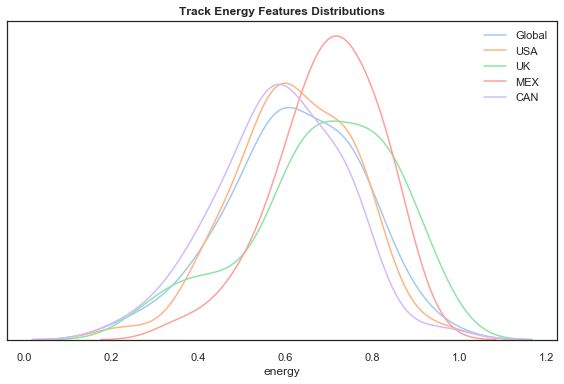

In [178]:
# Energy.

# Set up the matplotlib figure
f, axe = plt.subplots()
#sns.despine(left=True)

# Generate a random univariate dataset
#d = rs.normal(size=100)
global_energy = global_df['energy']
usa_energy = usa_df['energy']
uk_energy = uk_df['energy']
mex_energy = mex_df['energy']
can_energy = can_df['energy']

# Plot a histogram and kernel density estimate
sns.set(style="white", palette='pastel')
sns.distplot(global_energy, label='Global', hist=False, kde_kws={"shade": False})
sns.distplot(usa_energy, label='USA', hist=False, kde_kws={"shade": False})
sns.distplot(uk_energy, label='UK', hist=False, kde_kws={"shade": False})
sns.distplot(mex_energy, label='MEX', hist=False, kde_kws={"shade": False})
sns.distplot(can_energy, label='CAN', hist=False, kde_kws={"shade": False})
axe.set_title('Track Energy Features Distributions', fontweight='bold')
plt.setp(axe, yticks=[])
plt.tight_layout()

### Null Hypothesis: There is no difference in the mean of features in the USA and Global Playlists

In [171]:
# perform a two tailed t-test. Start with a function so that experiment can be repeated with other features.
def two_tailed_test(df1, df2, label1, label2, feature='energy'):
    '''
    mean_1 = df1[feature].mean()
    std_1 = df1[feature].std()
   
    mean_2 = df2[feature].mean()
    std_2 = df2[feature].mean()
    
    norm_dist_1 = stats.norm(mean_1, std_1)
    norm_dist_2 = stats.norm(mean_2, std_2)
    
    sample_1 = norm_dist_1.rvs(500)
    sample_2 = norm_dist_2.rvs(500)
    '''
   
    sample_1 = df1[feature]
    sample_2 = df2[feature]
    ztest,pval = stats.ttest_ind(sample_1, sample_2)
    print('pval = {}'.format(pval))
    if pval<0.05:
        print("reject null hypothesis")
    else:
        print("accept null hypothesis")
    
    #plot
    sns.set(style="white", palette='pastel')
    f, axe = plt.subplots()
    sns.distplot(sample_1, label=label1, hist=True, kde_kws={"shade": False})
    sns.distplot(sample_2, label=label2, hist=True, kde_kws={"shade": False})
    axe.set_title('Track "{}" Features Distributions'.format(feature), fontweight='bold')
    axe.legend(frameon=True)
    #plt.setp(axe, yticks=[])
    plt.tight_layout()
    
    return

pval = 0.612864976409074
accept null hypothesis


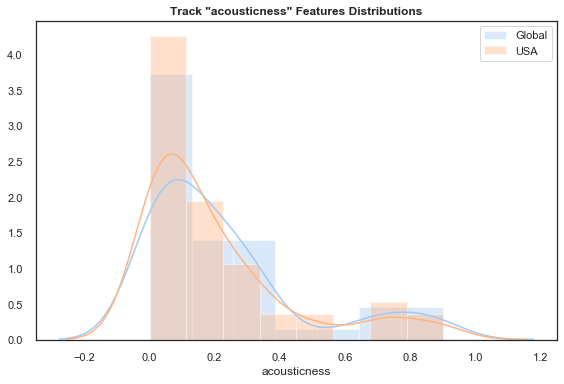

In [172]:
two_tailed_test(global_df, usa_df, label1='Global', label2='USA', feature='acousticness')

pval = 0.9898624889912536
accept null hypothesis


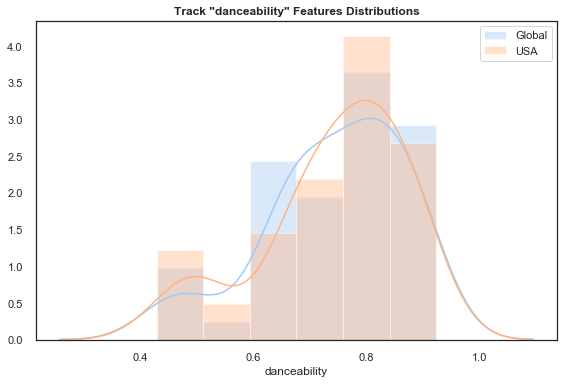

In [173]:
two_tailed_test(global_df, usa_df, label1='Global', label2='USA', feature='danceability')

pval = 0.9966979993191145
accept null hypothesis


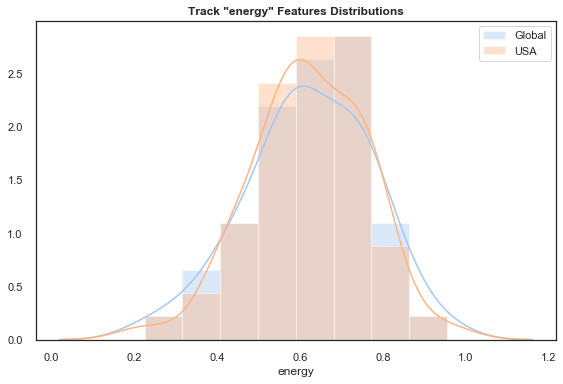

In [174]:
two_tailed_test(global_df, usa_df, label1='Global', label2='USA', feature='energy')

pval = 0.8747541155125537
accept null hypothesis


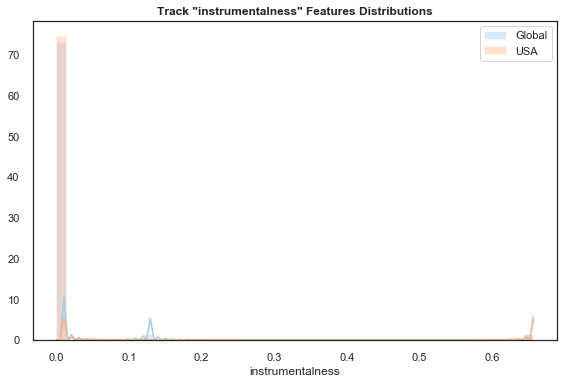

In [175]:
two_tailed_test(global_df, usa_df, label1='Global', label2='USA', feature='instrumentalness')

pval = 0.6585050655009175
accept null hypothesis


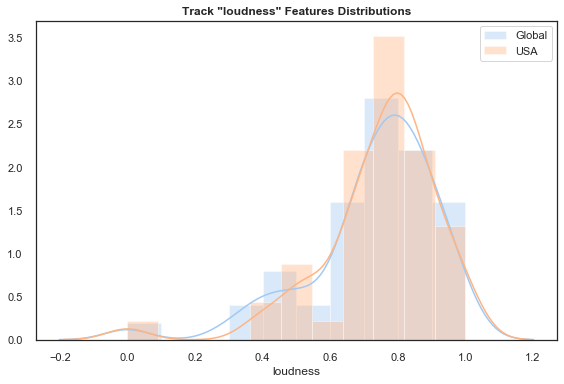

In [176]:
two_tailed_test(global_df, usa_df, label1='Global', label2='USA', feature='loudness')

pval = 0.7483005130667619
accept null hypothesis


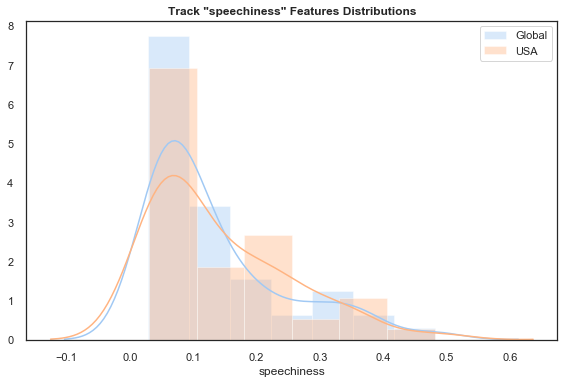

In [177]:
two_tailed_test(global_df, usa_df, label1='Global', label2='USA', feature='speechiness')

### Feature Descriptions

<img src="features_table.png">